In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_sine_wave(n_samples, frequency, sampling_intervals):
    t = np.cumsum(sampling_intervals)
    y = np.sin(2 * np.pi * frequency * t)
    return torch.tensor(y, dtype=torch.float32).unsqueeze(1)

def generate_sampling_intervals(n_samples, interval_range):
    return np.random.uniform(interval_range[0], interval_range[1], n_samples).astype(np.float32)


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out)

class LSTM_WA(nn.Module):
    def __init__(self, input_size, hidden_size, window_size):
        super(LSTM_WA, self).__init__()
        self.window_size = window_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, intervals):
        x_windowed = []
        for i in range(len(x)):
            window = x[max(0, i - self.window_size + 1):i + 1]
            x_windowed.append(window.mean(0))
        x_windowed = torch.stack(x_windowed)
        lstm_out, _ = self.lstm(x_windowed.unsqueeze(1))
        return self.linear(lstm_out)

# TG-LSTM은 이미 주어진 코드를 사용합니다.

In [8]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.jit as jit
from collections import namedtuple
from typing import List, Tuple
from torch import Tensor
import math


'''
Some helper classes for writing custom TorchScript LSTMs.
Goals:
- Classes are easy to read, use, and extend
- Performance of custom LSTMs approach fused-kernel-levels of speed.
A few notes about features we could add to clean up the below code:
- Support enumerate with nn.ModuleList:
  https://github.com/pytorch/pytorch/issues/14471
- Support enumerate/zip with lists:
  https://github.com/pytorch/pytorch/issues/15952
- Support overriding of class methods:
  https://github.com/pytorch/pytorch/issues/10733
- Support passing around user-defined namedtuple types for readability
- Support slicing com/pytorch/pytorch/issues/10774
- Multiline type annotations. List[List[Tuple[Tensor,Tensor]]] is verbose
  https://github.com/pytorch/pytorch/pull/14922
'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def TGLSTM(input_size, hidden_size, num_layers, bias=True,
                batch_first=False, dropout=False, bidirectional=False):
    '''Returns a ScriptModule that mimics a PyTorch native LSTM.'''

    # The following are not implemented.
    assert bias
    assert not batch_first
    assert not dropout

    if bidirectional:
        stack_type = StackedLSTM2
        layer_type = BidirLSTMLayer
        dirs = 2
    else:
        stack_type = StackedLSTM
        layer_type = LSTMLayer
        dirs = 1

    return stack_type(num_layers, layer_type,
                      first_layer_args=[LSTMCell, input_size, hidden_size],
                      other_layer_args=[LSTMCell, hidden_size * dirs,
                                        hidden_size])


LSTMState = namedtuple('LSTMState', ['hx', 'cx'])


def reverse(lst):
    # type: (List[Tensor]) -> List[Tensor]
    return lst[::-1]

class LSTMCell(torch.nn.Module):
    def __init__(self, input_features, state_size):
        super(LSTMCell, self).__init__()
        self.input_features = input_features
        self.state_size = state_size
        # 4 * state_size for input gate, output gate, forget gate and candidate cell gate.
        # input_features + state_size because we will multiply with [input, h].
        self.weights = torch.nn.Parameter(
            torch.Tensor(4 * state_size, input_features + state_size))
        self.bias = torch.nn.Parameter(torch.Tensor(1, 4 * state_size))
        self.weight_t = torch.nn.Parameter(torch.Tensor(3 * state_size, 1))
        self.bias_t = torch.nn.Parameter(torch.Tensor(1, 3 * state_size))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.state_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input, time, state):
        if state is None:
            old_h = input.new_zeros(input.size(0), self.state_size, requires_grad=False)
            old_cell = input.new_zeros(input.size(0), self.state_size, requires_grad=False)
        else:
            old_h, old_cell = state
            
        X = torch.cat([old_h, input], dim=1)
        # Compute the input, output and candidate cell gates with one MM.
        gate_weights = F.linear(X, self.weights, self.bias)
        time_weights = F.linear(time, self.weight_t, self.bias_t)
        # Split the combined gate weight matrix into its components.
        ingate, forgetgate, cellgate, outgate = gate_weights.chunk(4, dim=1)
        ingate_t, forgetgate_t, outgate_t = time_weights.chunk(3, dim=1)
        
        input_gate = torch.sigmoid(ingate)
        output_gate = torch.sigmoid(outgate)
        forget_gate = torch.sigmoid(forgetgate)
        candidate_cell = torch.tanh(cellgate)
        
        input_gate_t = torch.sigmoid(ingate_t)
        output_gate_t = torch.sigmoid(outgate_t)
        forget_gate_t = torch.sigmoid(forgetgate_t)

        #******************* TEST PURPOSE ONLY
        # set time gates to ones to get an equivalent classic LSTM
#        input_gate_t = input_gate_t.new_ones(input_gate_t.size(0), input_gate_t.size(1))
#        forget_gate_t = forget_gate_t.new_ones(forget_gate_t.size(0), forget_gate_t.size(1))
#        output_gate_t = output_gate_t.new_ones(output_gate_t.size(0), output_gate_t.size(1))
        #*******************

        # Compute the new cell state.
        new_cell = old_cell * forget_gate * forget_gate_t + candidate_cell * input_gate * input_gate_t
        # Compute the new hidden state and output.
        new_h = torch.tanh(new_cell) * output_gate * output_gate_t

        return new_h, (new_h, new_cell)

class LSTMLayer(nn.Module):
    def __init__(self, cell, *cell_args):
        super(LSTMLayer, self).__init__()
        self.cell = cell(*cell_args)

    def forward(self, input, time, state=None):
        inputs = input.unbind(0)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], time[i], state)
            outputs += [out]
        return torch.stack(outputs), state


class ReverseLSTMLayer(nn.Module):
    def __init__(self, cell, *cell_args):
        super(ReverseLSTMLayer, self).__init__()
        self.cell = cell(*cell_args)

    def forward(self, input, time, state=None):
        inputs = reverse(input.unbind(0))
        times = reverse(time.unbind(0))
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], times[i], state)
            outputs += [out]
        return torch.stack(reverse(outputs)), state


class BidirLSTMLayer(nn.Module):
    __constants__ = ['directions']

    def __init__(self, cell, *cell_args):
        super(BidirLSTMLayer, self).__init__()
        self.directions = nn.ModuleList([
            LSTMLayer(cell, *cell_args),
            ReverseLSTMLayer(cell, *cell_args),
        ])

    def forward(self, input, time, states=None):
        outputs = []
        output_states = []
        for i, direction in enumerate(self.directions):
            if states is None:
                state = None
            else:
                state = states[i]
            out, out_state = direction(input, time, state)
            outputs += [out]
            output_states += [out_state]
        return torch.cat(outputs, -1), output_states


def init_stacked_lstm(num_layers, layer, first_layer_args, other_layer_args):
    layers = [layer(*first_layer_args)] + [layer(*other_layer_args)
                                           for _ in range(num_layers - 1)]
    return nn.ModuleList(layers)


class StackedLSTM(nn.Module):
    __constants__ = ['layers']  # Necessary for iterating through self.layers

    def __init__(self, num_layers, layer, first_layer_args, other_layer_args):
        super(StackedLSTM, self).__init__()
        self.layers = init_stacked_lstm(num_layers, layer, first_layer_args,
                                        other_layer_args)

    def forward(self, input, time, states=None):
        output_states = []
        output = input
        i = 0
        for rnn_layer in self.layers:
            if states is None:
                state = None
            else:
                state = states[i]
            output, out_state = rnn_layer(output, time, state)
            output_states += [out_state]
            i += 1        
        return output, output_states


# Differs from StackedLSTM in that its forward method takes
# List[List[Tuple[Tensor,Tensor]]]. It would be nice to subclass StackedLSTM
# except we don't support overriding script methods.
# https://github.com/pytorch/pytorch/issues/10733
class StackedLSTM2(nn.Module):
    __constants__ = ['layers']  # Necessary for iterating through self.layers

    def __init__(self, num_layers, layer, first_layer_args, other_layer_args):
        super(StackedLSTM2, self).__init__()
        self.layers = init_stacked_lstm(num_layers, layer, first_layer_args,
                                        other_layer_args)

    def forward(self, input, time, states=None):
        # type: (Tensor, List[List[Tuple[Tensor, Tensor]]]) -> Tuple[Tensor, List[List[Tuple[Tensor, Tensor]]]]
        # List[List[LSTMState]]: The outer list is for layers,
        #                        inner list is for directions.
        output_states = []
        output = input
        i = 0
        for rnn_layer in self.layers:
            if states is None:
                state = None
            else:
                state = states[i]
            output, out_state = rnn_layer(output, time, state)
            output_states += [out_state]
            i += 1
        return output, output_states

def flatten_states(states):
    states = list(zip(*states))
    assert len(states) == 2
    return [torch.stack(state) for state in states]

def double_flatten_states(states):
    states = flatten_states([flatten_states(inner) for inner in states])
    return [hidden.view([-1] + list(hidden.shape[2:])) for hidden in states]

In [9]:
def train_model(model, X, y, intervals, epochs, lr):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        if isinstance(model, LSTM_WA):
            outputs = model(X, intervals)
        elif isinstance(model, LSTM):
            outputs = model(X.unsqueeze(1))
        else:  # TG-LSTM case
            outputs, _ = model(X.unsqueeze(0), intervals.unsqueeze(0))
            outputs = outputs.squeeze(0)
        
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    return losses

def evaluate_model(model, X, y, intervals):
    model.eval()
    with torch.no_grad():
        if isinstance(model, LSTM_WA):
            outputs = model(X, intervals)
        elif isinstance(model, LSTM):
            outputs = model(X.unsqueeze(1))
        else:  # TG-LSTM case
            outputs, _ = model(X.unsqueeze(0), intervals.unsqueeze(0))
            outputs = outputs.squeeze(0)
        
        loss = nn.MSELoss()(outputs, y)
    return loss.item()

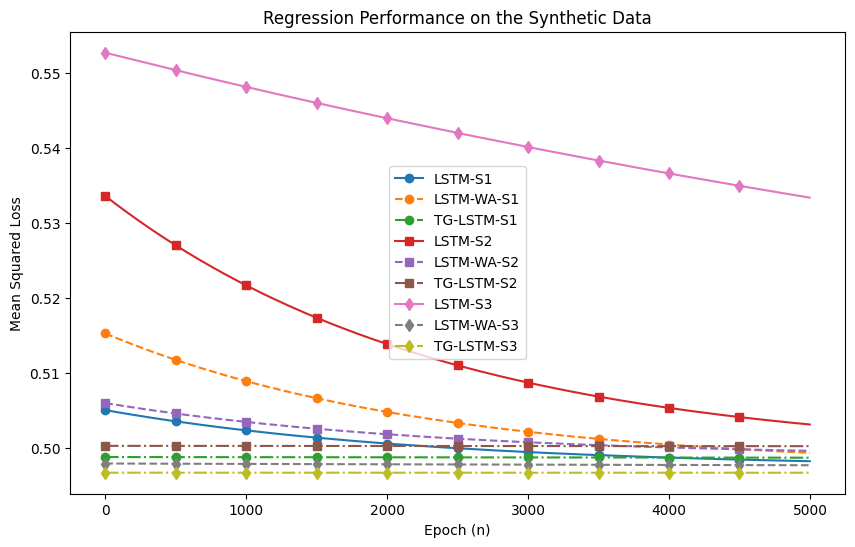

In [10]:
scenarios = [
    {"name": "S1", "interval_range": (0.002, 0.01), "lr": 1e-4},
    {"name": "S2", "interval_range": (0.005, 0.02), "lr": 1e-4},
    {"name": "S3", "interval_range": (0.02, 0.05), "lr": 2e-5}
]

n_samples = 1000
frequency = 10
hidden_size = 20
input_size = 1
epochs = 5000

# Plot results
plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.']  # 모델별 선 스타일
markers = ['o', 's', 'd']  # 시나리오별 마커 

for i, scenario in enumerate(scenarios):
    # print(f"Running scenario: {scenario['name']}")

    # Generate data
    intervals = generate_sampling_intervals(n_samples, scenario['interval_range'])
    X = generate_sine_wave(n_samples, frequency, intervals)
    y = torch.roll(X, -1, 0)

    # Convert intervals to tensor and ensure float32 dtype
    intervals_tensor = torch.tensor(intervals, dtype=torch.float32)

    # Train and evaluate models
    lstm = LSTM(input_size, hidden_size)
    lstm_wa = LSTM_WA(input_size, hidden_size, window_size=int(scenario['interval_range'][1] * 1000))
    tg_lstm = TGLSTM(input_size, hidden_size, num_layers=1)

    lstm_losses = train_model(lstm, X, y, intervals_tensor, epochs, scenario['lr'])
    lstm_wa_losses = train_model(lstm_wa, X, y, intervals_tensor, epochs, scenario['lr'])
    tg_lstm_losses = train_model(tg_lstm, X, y, intervals_tensor.unsqueeze(1), epochs, scenario['lr'])

    plt.plot(lstm_losses, linestyle=line_styles[0], marker=markers[i], markevery=500, label=f'LSTM-{scenario["name"]}')
    plt.plot(lstm_wa_losses, linestyle=line_styles[1], marker=markers[i], markevery=500, label=f'LSTM-WA-{scenario["name"]}')
    plt.plot(tg_lstm_losses, linestyle=line_styles[2], marker=markers[i], markevery=500, label=f'TG-LSTM-{scenario["name"]}')

plt.xlabel('Epoch (n)')
plt.ylabel('Mean Squared Loss')
plt.title('Regression Performance on the Synthetic Data')
plt.legend()
plt.show()